# Example 6: Parkhurst and Appelo 2013 (PHREEQC-3 Example 11) 3D variant of Cation Exchange with DISV grid

This notebook demonstrates a 3D varriant of the MF6RTM benchmark Example 4 and also utilizes the DISV package for the MODFLOW 6 model grid. The example was originally used as PHREEQM (Nienhuis et al., 1994) test case, and is also included in the PHREEQC-3 documentation (Parkhurst and Appelo, 2013) as Example 11. Further discussion can be found in (Appelo and Postma, 1993), where it forms Example 10.13, and in (Appelo, 1994). The one-dimensional simulation problem describes a hypothetical column experiment where porewater containing sodium (Na<sup>+</sup>), potassium (K<sup>+</sup>) and nitrate (NO<sup>-</sup><sub>3</sub>) in equilibrium with exchangeable cations is flushed by a calcium chloride (CaCl<sub>2</sub>) solution.

The workflow for this example starts with loading a pre-existing MODFLOW 6 model, then builds the PHREEQC yaml file from scratch based off of the MODFLOW 6 input file parameters. The input files required for the MODFLOW 6 model are located in the ex6 directory.   

# Installation and Setup

This notebook is designed to be run from:   
- a custom [conda](https://docs.conda.io/en/latest/) virtual environment as described in our [Install Development Environment](benchmark/readme.md) instructions, especially including:
  - Creating a custom virtual environment using the `environment.yml` file included in this folder (step 3)
  - Adding this repository to your conda path (step 4)

## Python Imports

In [ ]:
import os
from pathlib import Path
from importlib import reload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import flopy
import phreeqcrm

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute


In [2]:
# Import the MFRTM package, installed using `conda develop`
import mf6rtm

### If you get `ModuleNotFoundError`

If you get `ModuleNotFoundError`, you need to install `mf6rtm` into your environment.

If using the development environment, the following steps will install in develop mode:
1. Run the [`conda develop`](https://docs.conda.io/projects/conda-build/en/latest/resources/commands/conda-develop.html) command in your terminal with your local absolute path to the `src` directory of this repo.
2. Restart the kernel.
3. Rerun the import statements above.

In [3]:
# Find your current working directory, which should be folder for this notebook.
working_dir = Path.cwd()

# Find project directory (i.e. the parent to `/examples` directory for this notebook)
project_path = working_dir.parent.parent.parent
project_path

PosixPath('/Users/aaufdenkampe/Documents/Python/modflow-modeling')

In [4]:
# If MF6RTM is installed in the same directory as this project, 
# then `mf6rtm_source_path` should be the source directory
mf6rtm_path = project_path.parent / 'mf6rtm'
mf6rtm_source_path = mf6rtm_path / 'src'
print(mf6rtm_source_path)
mf6rtm_source_path.exists()

/Users/aaufdenkampe/Documents/Python/mf6rtm/src


True

### To install in developer mode:
- Confirm that the output of `src_path` points to the MF6RTM `src` directory 
- Uncomment and run the line below.
- NOTE 1: The Jupyter [`%conda` magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-conda) runs conda terminal commands directly from this notebook.
- NOTE 2: We can inject Python string objects into magic commmands using a syntax similar to Python's F-strings.

In [5]:
# %conda develop {mf6rtm_source_path}

If the path was added, Restart the kernel and rerun the cells above.

## Set Paths to Input and Output Files with `pathlib` 

Use the [pathlib](https://docs.python.org/3/library/pathlib.html) library (built-in to Python 3) to manage paths indpendentely of OS or environment. See this [blog post](https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f) to learn about the many benefits over using the `os` library.

In [6]:
project_path

PosixPath('/Users/aaufdenkampe/Documents/Python/modflow-modeling')

In [ ]:
# Set the simulation name
sim_name = 'ex6'

In [ ]:
# Path to MF6 inputs created by 
# modflow-modeling/examples/flopy/phreeqc_ex11/MF6_ex11_disv_3D.py
mf6_input_path = project_path / 'examples'/'flopy'/'phreeqc_ex11'/'outputs'/ sim_name
mf6_input_path

PosixPath('/Users/aaufdenkampe/Documents/Python/modflow-modeling/examples/flopy/phreeqc_ex11/outputs/disvM3Db')

# Write/Load Modflow 6 Model Simulation Info using Flopy
To set up PhreeqcRM and MF6RTM simulation objects. Creates Modflow 6 input files, if they don't already exit. 

In [ ]:
# Functions for writting and running the Modflow 6 input files

def build_models(name, inflow):
    print(f"Building model...{name}")

    sim_ws = os.path.join(workspace, name)
    if not os.path.exists(sim_ws):
        os.makedirs(sim_ws)
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name=mf6_exe)
    
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen, nstp, 1.0))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)
    
    ### Begin GWF
    gwf_name = "gwf_" + name
    
    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwf_name, save_flows=True)
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        complexity="complex",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwf.name}.ims")
    sim.register_ims_package(imsgwf, [gwf.name])

    nlay = 2
    nrow = 2
    ncol = 40
    delc = 0.5 # (m)
    delr = 0.01 #Lx/ncol (m)
    Lx = ncol*delr #0.08 (m)
    top = 1. # (m)
    zbotm = 0. # (m)
    botm = np.linspace(top,zbotm,nlay + 1)[1:]
    ncpl = ncol*nrow

    # load in grid info from csv files
    vertices_csv = np.genfromtxt(v_file_path, delimiter=',', names=True, dtype=None, encoding='utf-8')
    vertices_recdata = vertices_csv.view(np.recarray)
    cell2d_csv = np.genfromtxt(c_file_path, delimiter=',', names=True, dtype=None, encoding='utf-8')
    cell2d_recdata = cell2d_csv.view(np.recarray)
    
    nvert = len(vertices_recdata)

    disv = flopy.mf6.ModflowGwfdisv(
        gwf,
        nlay=nlay,
        ncpl=ncpl,
        nvert=nvert,
        top=top,
        botm=botm,
        vertices=vertices_recdata,
        cell2d=cell2d_recdata,
        filename = f"{gwf.name}.disv"
        )
    
    # get propeties for gwt disv
    nlay_gwf = gwf.disv.nlay.array
    ncpl_gwf = gwf.disv.ncpl.array 
    top_gwf = gwf.disv.top.array
    botm_gwf = gwf.disv.botm.array
    nverts_gwf = gwf.disv.nvert.array
    vertices_gwf = gwf.disv.vertices.array
    cell2d_gwf = gwf.disv.cell2d.array
    
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        icelltype=1,
        k=hydraulic_conductivity)
    
    icgwf = flopy.mf6.ModflowGwfic(gwf, strt=initial_heads)

    chdspd = [[(0,39),chd_head],[(0,79),chd_head],[(1,39),chd_head],[(1,79),chd_head]]  
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chdspd,
        pname="CHD-1")

    wel_cell_idx = [(0,0),(0,40),(1,0),(1,40)]
    welspd = []
    for c in range(len(wel_cell_idx)):
        welspd.append([wel_cell_idx[c],inflow,*inflow_conc])
    auxiliary_vars = [f"CONCENTRATION_{solute}" for solute in solute_names]
    wel = flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=welspd,
        pname="WEL-1",
        auxiliary=auxiliary_vars)
    
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    ocgwf = flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])
    ### End GWF
    
    ### Begin GWT
    for c in range(len(solute_names)):
        gwt_name = 'gwt_' + solute_names[c]

        gwt = flopy.mf6.ModflowGwt(sim, modelname=gwt_name)
        imsgwt = flopy.mf6.ModflowIms(
            sim,
            print_option="ALL",
            outer_dvclose=hclose,
            outer_maximum=nouter,
            under_relaxation="NONE",
            inner_maximum=ninner,
            inner_dvclose=hclose,
            rcloserecord=rclose,
            linear_acceleration="BICGSTAB",
            scaling_method="NONE",
            reordering_method="NONE",
            relaxation_factor=relax,
            filename=f"{gwt.name}.ims")
    
        sim.register_ims_package(imsgwt, [gwt.name])

        disvgwt = flopy.mf6.ModflowGwtdisv(
            gwt,
            length_units=length_units,
            nlay=nlay_gwf,
            ncpl=ncpl_gwf,
            nvert=nverts_gwf,
            top=top_gwf,
            botm=botm_gwf,
            vertices=vertices_gwf,
            cell2d=cell2d_gwf,
        )
        mst = flopy.mf6.ModflowGwtmst(
            gwt, 
            porosity=porosity,
            first_order_decay=None)
        
        icgwt = flopy.mf6.ModflowGwtic(gwt, strt=ic_conc_l[c])
        
        adv = flopy.mf6.ModflowGwtadv(gwt, scheme="tvd")
        
        dsp = flopy.mf6.ModflowGwtdsp(
            gwt,
            xt3d_off=True,
            alh=dispersivity,
            ath1=dispersivity*0.1,
            atv=dispersivity*0.1)
        
        sourcerecarray = [("WEL-1", "AUX", "CONCENTRATION_"+solute_names[c])]
        ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
        
        ocgwt = flopy.mf6.ModflowGwtoc(
            gwt,
            budget_filerecord=f"{gwt.name}.cbc", 
            concentration_filerecord=f"{gwt.name}.ucn",
            concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
            saverecord=[("CONCENTRATION", "ALL")])
        
        gwfgwt = flopy.mf6.ModflowGwfgwt(
            sim, exgtype="GWF6-GWT6", exgmnamea=gwf.name, exgmnameb=gwt.name,
            filename='gwfgwt_'+solute_names[c]+'.gwfgwt')
        
    ### End GWT
    
    return sim

def write_models(sim, silent=True):
    
    ''' writes modflow 6 input files'''
    
    sim.write_simulation(silent=silent)

def run_models(sim, silent=True):
    
    '''runs modflow 6 simulation'''
    
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff


In [ ]:
# Path to simulation workspace
sim_ws = mf6_input_path

In [ ]:
# checks to see if Modflow 6 input files already exist
sim_nam_file_path = sim_ws / "mfsim.nam"

if sim_nam_file_path.exists():
    sim = flopy.mf6.MFSimulation.load(
        sim_ws=sim_ws,
        exe_name='mf6',
        verbosity_level=0,
    )
else:
    # additional parameters required for creating Modflow 6 input files
    nper = 1  # Number of periods
    tstep = 0.001 #0.002 *0.5 # timestep (days)
    perlen = 0.24 #nper * [time_end / nper]  # Simulation time length (d)
    nstp = perlen/tstep  # Number of time steps    

    hydraulic_conductivity = 1.  # Hydraulic conductivity (m/d)
    porosity = 1  # porosity (unitless)
    diffusion_coefficient = 0.57024  # diffusion coefficient (m^2/d)
    dispersivity = 0.002 # Longitudinal dispersivity (m) 

    initial_heads = 1.
    solute_names = [
        'H', 'O', 'Ch', 'Ca', 
        'Cl', 'K', 'N', 'Na',
    ]
    inflow_conc  = [   # units = mol/L 
        110684.00, 55342.0856, -0.0000013109877, 0.59822581,
        1.19645161, 0.0000, 0.0000, 0.0000,
    ] 
    nsolutes = len(solute_names)
    # initial concentration of each solute in solute_names
    ic_conc_l = [       # units = mol/L
        110684.1711486, 55345.67494365, -0.000000337912141, 0.0,
        0.0, 0.19940729, 1.19645161, 0.99703984,
    ] 

    chd_head = 1. # (m)
    inflow = 0.25 # flow rate into column m3/d

    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-9, 1e-6, 0.97 

    # full path to disv package verticies .csv file 
    v_file_path = "C:\\Users\\...\\3Dncol40_vert.csv"
    # full path to disv package cell2d .csv file 
    c_file_path = "C:\\Users\\...\\3Dncol40_cell.csv"

    # create simulation and write Modflow 6 input files
    sim = build_models(sim_name, inflow)
    write_models(sim, silent=False)

In [ ]:
# view Modflow 6 models within the simulation
sim.model_names

['gwf_disvm3db',
 'gwt_h',
 'gwt_o',
 'gwt_ch',
 'gwt_ca',
 'gwt_cl',
 'gwt_k',
 'gwt_n',
 'gwt_na']

## Read GWT Model Names & Initial Conditions

In [29]:
# get gwt components and initial conditions
ic_dict = {}
# NOTE: this assumes names of gwt models are the component names 
for mname in sim.model_names:
    m = sim.get_model(mname)
    if m.model_type == 'gwt6':
        # get initial conditions
        assert hasattr(m, 'ic'), f"GWT model '{m.name}' is missing an 'ic' package."
        ic_dict[m.name] = m.ic.strt.array
        
gwt_model_names = list(ic_dict.keys())
gwt_model_names

['gwt_h', 'gwt_o', 'gwt_ch', 'gwt_ca', 'gwt_cl', 'gwt_k', 'gwt_n', 'gwt_na']

### Create Chem Component: GWT Model Dictionary

In [32]:
components = ['H', 'O', 'Charge', 'Ca', 'Cl', 'K', 'N', 'Na']
component_gwt_model_dict = dict(zip(components, gwt_model_names))
component_gwt_model_dict

{'H': 'gwt_h',
 'O': 'gwt_o',
 'Charge': 'gwt_ch',
 'Ca': 'gwt_ca',
 'Cl': 'gwt_cl',
 'K': 'gwt_k',
 'N': 'gwt_n',
 'Na': 'gwt_na'}

## Read Time Step Info

In [33]:
# Get time discretization info from the `tdis` package
tdis = sim.tdis
nper = tdis.nper.get_data()          # number of stress periods
perioddata = tdis.perioddata.get_data()
nstp = perioddata['nstp']            # number of timesteps per stress period
perlen = perioddata['perlen']        # lenght of stress periods
tsmult = perioddata['tsmult']        # timestep multiplier
t_units = tdis.time_units.get_data() # units

print(nper, nstp, perlen, tsmult, t_units)

1 [240] [0.24] [1.] days


## Read Stress Period Info

In [ ]:
# get boundary condition packages with transport

# for well package (wel):
wel = gwf_model.get_package('wel')
if wel.has_stress_period_data == True:
    spd_wel_dict = wel.stress_period_data.get_data()
    print(spd_wel_dict)

{0: rec.array([((0, 0), 0.25, 110684., 55342.0856, -1.3109877e-06, 0.59822581, 1.19645161, 0., 0., 0.),
           ((0, 40), 0.25, 110684., 55342.0856, -1.3109877e-06, 0.59822581, 1.19645161, 0., 0., 0.),
           ((1, 0), 0.25, 110684., 55342.0856, -1.3109877e-06, 0.59822581, 1.19645161, 0., 0., 0.),
           ((1, 40), 0.25, 110684., 55342.0856, -1.3109877e-06, 0.59822581, 1.19645161, 0., 0., 0.)],
          dtype=[('cellid', 'O'), ('q', '<f8'), ('concentration_h', '<f8'), ('concentration_o', '<f8'), ('concentration_ch', '<f8'), ('concentration_ca', '<f8'), ('concentration_cl', '<f8'), ('concentration_k', '<f8'), ('concentration_n', '<f8'), ('concentration_na', '<f8')])}


In [35]:
# data stored in numpy record arrays
spd_wel_dict[0].dtype.fields.keys()

dict_keys(['cellid', 'q', 'concentration_h', 'concentration_o', 'concentration_ch', 'concentration_ca', 'concentration_cl', 'concentration_k', 'concentration_n', 'concentration_na'])

In [36]:
spd_wel_dict[0]['cellid']

array([(0, 0), (0, 40), (1, 0), (1, 40)], dtype=object)

NOTE: `cellid` is the cell identifier, and depends on the type of grid that is used for the simulation. 
- For a structured grid that uses the DIS input file, CELLID is the layer, row, and column. 
- For a grid that uses the DISV input file, CELLID is the layer and CELL2D number. 
- If the model uses the unstructured discretization (DISU) input file, CELLID is the node number for the cell.

In [37]:
# injection rate
# q = 1 #injection rate m3/d
spd_wel_dict[0]['q']

array([0.25, 0.25, 0.25, 0.25])

### Create Chem Component: Auxilary Variable Dictionary

In [ ]:
# Create dictionary of auxiliary variables for spress period package
welchem_dict = {}
component_spd_auxvar_dict = {}
auxvar_prefix = 'concentration_'
for n in range(0,nper):
    for component in components:
        component_code = component.lower()
        if component_code == 'charge':
            component_code = 'ch'
        welchem_dict[component] = spd_wel_dict[n][f'{auxvar_prefix}{component_code}']
        component_spd_auxvar_dict[component] = f'{auxvar_prefix}{component_code}'
welchem_dict

{'H': array([110684., 110684., 110684., 110684.]),
 'O': array([55342.0856, 55342.0856, 55342.0856, 55342.0856]),
 'Charge': array([-1.3109877e-06, -1.3109877e-06, -1.3109877e-06, -1.3109877e-06]),
 'Ca': array([0.59822581, 0.59822581, 0.59822581, 0.59822581]),
 'Cl': array([1.19645161, 1.19645161, 1.19645161, 1.19645161]),
 'K': array([0., 0., 0., 0.]),
 'N': array([0., 0., 0., 0.]),
 'Na': array([0., 0., 0., 0.])}

In [42]:
component_spd_auxvar_dict

{'H': 'concentration_h',
 'O': 'concentration_o',
 'Charge': 'concentration_ch',
 'Ca': 'concentration_ca',
 'Cl': 'concentration_cl',
 'K': 'concentration_k',
 'N': 'concentration_n',
 'Na': 'concentration_na'}

# Run Modflow 6 simulation only

In [44]:
sim.run_simulation(silent=False)

FloPy is using the following executable to run the model: ../../../../../../../../miniconda3/envs/modflow/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

        MODFLOW 6 compiled Feb 11 2025 19:25:23 with GCC version 13.2.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer t

(True, [])

## Plot MF6 Transport Results with no Reactions

When just running MF6, before any coupling.

NOTE: `conc = sim.get_model(gwt_model_name).output.concentration().get_alldata()` returns:  

```python
conc[0].shape = 
    (240, 2, 1, 80)
#   ^     ^  ^  ^
#   |     |  |  number of cells per layer (ncpl = 40)
#   |     |  dummy row dimension (always 1 for DISV)
#   |     number of layers (nlay = 2)
#   number of time steps (240)
```


disvM3Db Cl gwt_cl (240, 2, 1, 80)


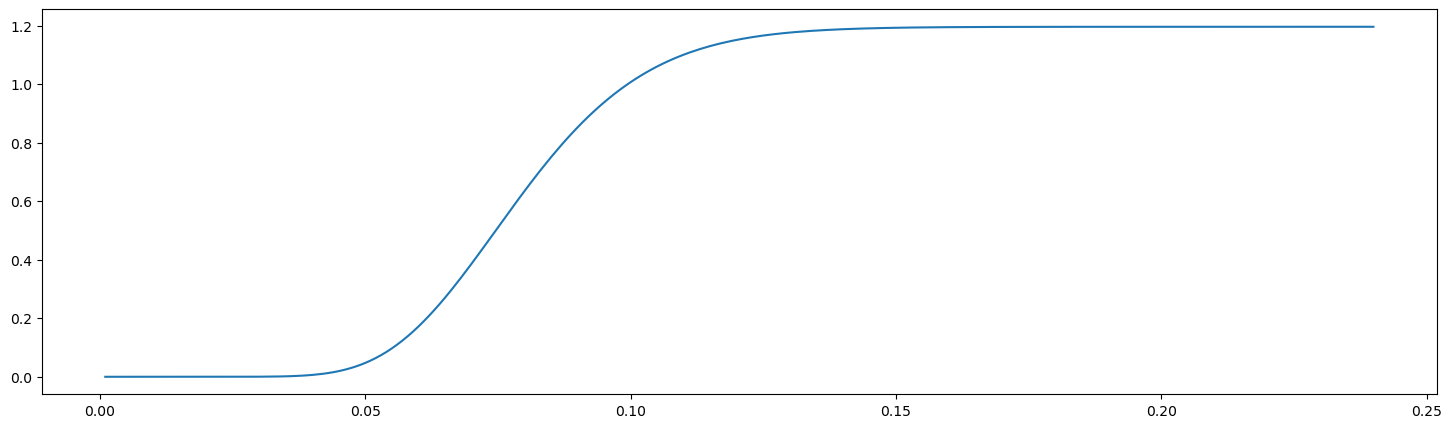

In [46]:
# Plot concentration results timeseries at last cell 
# for conservative species Chloride
component = 'Cl'
gwt_model_name = component_gwt_model_dict[component]
conc = sim.get_model(gwt_model_name).output.concentration().get_alldata()

times_list = sim.get_model(gwt_model_name).output.concentration().get_times()
times = np.array(times_list)

print(sim_name, component, gwt_model_name, conc.shape)
fig = plt.figure(figsize=(18, 5))
plt.plot(times, conc[:,0,0,-1])

disvM3Db Cl gwt_cl (240, 2, 1, 80)


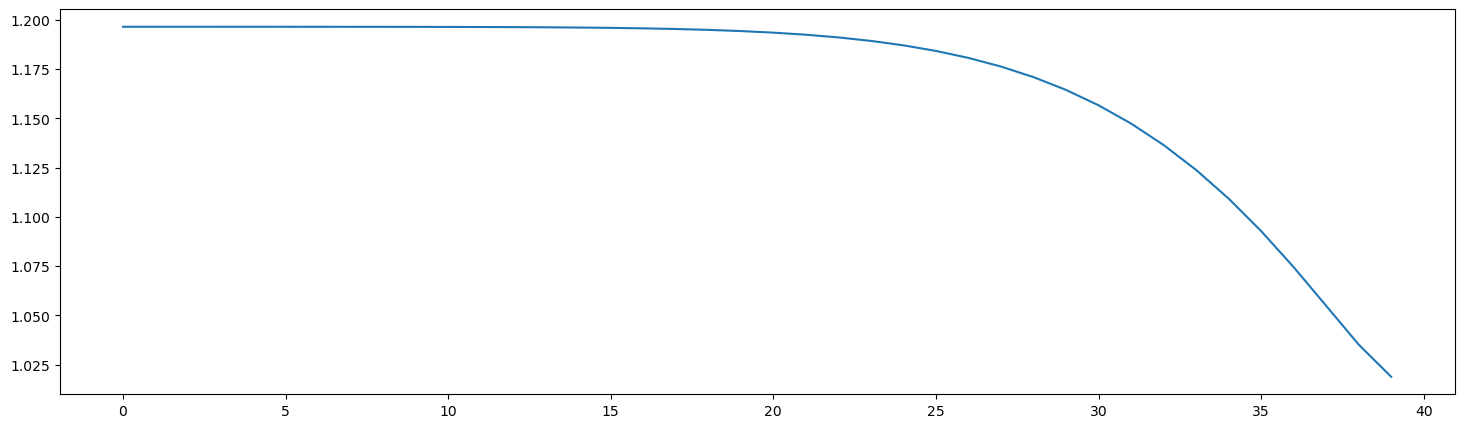

In [47]:
# Plot concentration results over grid (first layer) at specified timestep
timestep = 100
print(sim_name, component, gwt_model_name, conc.shape)
fig = plt.figure(figsize=(18, 5))
plt.plot(conc[timestep,0,0,:40])

disvM3Db Ca gwt_ca (240, 2, 1, 80)
disvM3Db K gwt_k (240, 2, 1, 80)


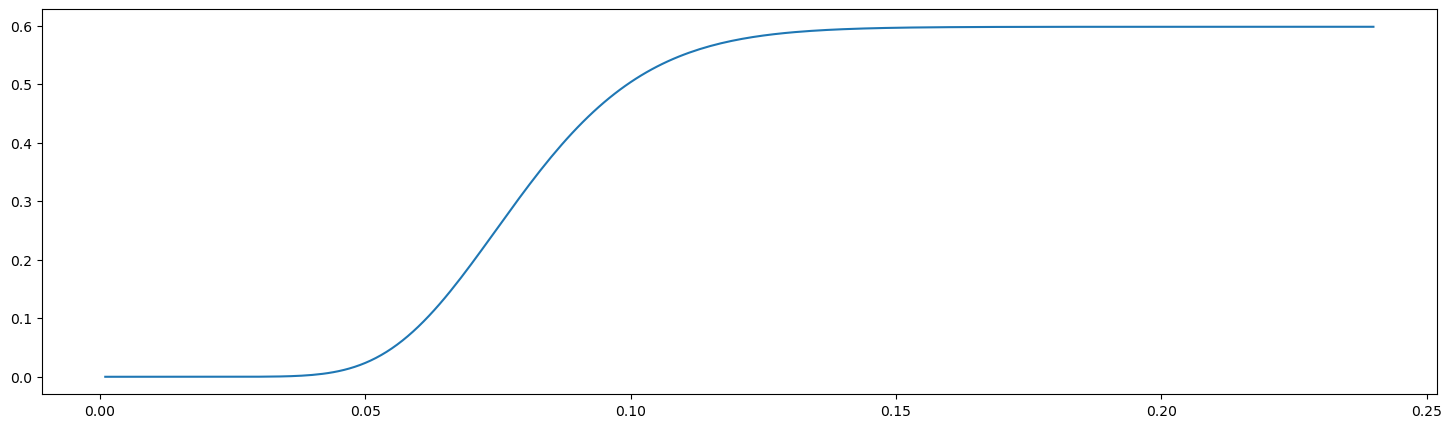

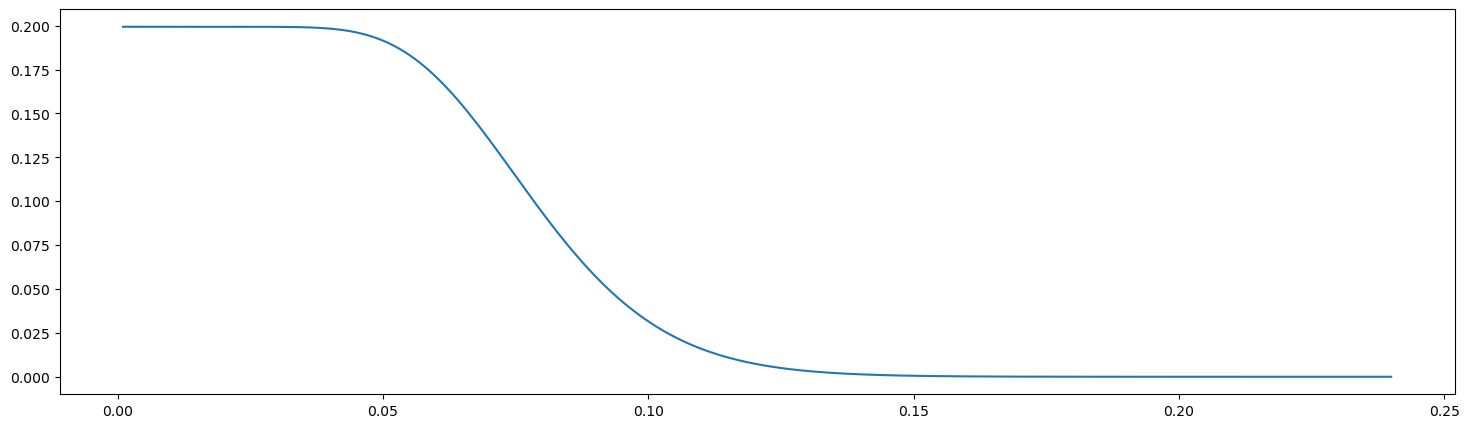

In [48]:
# Confirm breakthrough curves for other components mirror Cl
components = ['Ca', 'K']
for component in components:
    gwt_model_name = component_gwt_model_dict[component]
    conc = sim.get_model(gwt_model_name).output.concentration().get_alldata()
    print(sim_name, component, gwt_model_name, conc.shape)
    fig = plt.figure(figsize=(18, 5))
    plt.plot(times, conc[:,0,0,-1])

# Create PhreeqcRM YAML config file from scratch

Based on the [`phreeqcrm/swig/python/ex11-advect/ex11-advect.ipynb`](https://github.com/usgs-coupled/phreeqcrm/blob/master/swig/python/ex11-advect/ex11-advect.ipynb) example notebook

## Initialize YAML file and set grid size

In [73]:
# Create YAMLPhreeqcRM document object
yrm = phreeqcrm.YAMLPhreeqcRM()

In [ ]:
# Number of grid cells, read in from the Modflow 6

# Read the grid type / discretization package name
for package_name in gwf_model.package_names:
    if 'dis' in package_name: 
        grid_package_name = package_name

# Get spatial discretization info, for DISV
grid_package = gwf_model.get_package(grid_package_name)
nlay = grid_package.nlay.get_data()  # number of layers
ncpl = grid_package.ncpl.get_data()  # number of cells per layer
print(nlay, ncpl)

# Calculate total number of grid cells
nxyz = nlay * ncpl
nxyz

160

In [75]:
# Set GridCellCount
yrm.YAMLSetGridCellCount(nxyz)  
    # Number of cells for the PhreeqcRM instance

## Set Properties

In [76]:
# Set these parameters here, 
# to match order in `Mup3d._write_phreeqc_init_file()`
yrm.YAMLThreadCount(1)
yrm.YAMLSetComponentH2O(False)
yrm.YAMLUseSolutionDensityVolume(False)

In [77]:
phreeqc_output_prefix = mf6_input_path / '_phreeqc'
phreeqc_output_prefix

PosixPath('/Users/aaufdenkampe/Documents/Python/modflow-modeling/examples/flopy/phreeqc_ex11/outputs/disvM3Db/_phreeqc')

In [78]:
# From `Mup3d._write_phreeqc_init_file()`

# Open files for phreeqcrm logging
yrm.YAMLSetFilePrefix(str(phreeqc_output_prefix))
yrm.YAMLOpenFiles()

In [79]:
yrm.YAMLSetErrorHandlerMode(1)   
    # 0 (default), return to calling program with an error return code; 
    # 1, throw an exception; 2, attempt to exit gracefully
# yrm.YAMLSetComponentH2O(False)              
    # True (default), excess H, excess O, and water are included in the 
    #   component list (require less accuracy in transport); 
    # False, total H and O are included in the component list (requires 
    #   transportresults to be accurate to eight or nine significant 
    #   digits)
yrm.YAMLSetRebalanceFraction(0.5)           
    # 0.5 (default); 
    # 0, eliminate load rebalancing; 
    # 1, maximum load rebalancing setting; 
    # Less than 1 recommended to avoid too many cells transferred at one 
    #   iteration
yrm.YAMLSetRebalanceByCell(True)            
    # True (default), individual cell times are used in rebalancing; 
    # False, average times are used in rebalancing
# yrm.YAMLUseSolutionDensityVolume(False)     
    # True, use solution density and volume as calculated by PHREEQC; 
    # False, use solution density set by SetDensityUser and the volume 
    #   determined by the product of  SetSaturationUser, SetPorosity, 
    #   and SetRepresentativeVolume
yrm.YAMLSetPartitionUZSolids(False)         
    # True, the fraction of solids and gases available for reaction is 
    #   equal to the saturation; 
    # False (default), all solids and gases are reactive regardless of 
    #   saturation

## Set Units

In [80]:
# Set concentration units
yrm.YAMLSetUnitsSolution(2)           
    # 1, mg/L; 2, mol/L; 3, kg/kgs
yrm.YAMLSetUnitsPPassemblage(1)       
    # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsExchange(1)           
    # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsSurface(1)            
    # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsGasPhase(1)           
    # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsSSassemblage(1)       
    # 0, mol/L cell; 1, mol/L water; 2 mol/L rock
yrm.YAMLSetUnitsKinetics(1)           
    # 0, mol/L cell; 1, mol/L water; 2 mol/L rock

In [81]:
# Set conversion from seconds to user units (days);
#   Only affects one print statement
time_conversion = 1.0 / 86400.0
# yrm.YAMLSetTimeConversion(time_conversion)      
    # Factor to convert seconds to user time units

## Set Initial Conditions

In [82]:
# Set these parameters here, 
# to match order in `Mup3d._write_phreeqc_init_file()`

# Set initial porosity
por = [1.0] * nxyz # mf6 handles porosity. Set to 1.
yrm.YAMLSetPorosity(por)                        
    # Porosity, unitless, for each reaction cell as an array of size 
    #   nxyz

In [83]:
# From `Mup3d._write_phreeqc_init_file()`

print_chemistry_mask = [1]*nxyz
yrm.YAMLSetPrintChemistryMask(print_chemistry_mask)
yrm.YAMLSetPrintChemistryOn(False, True, False)  # workers, initial_phreeqc, utility


In [84]:
# Set representative volume
rv = [1] * nxyz                                 
yrm.YAMLSetRepresentativeVolume(rv)             
    # Representative volumes, in liters, of each reaction cell as an 
    #   array of size nxyz. Default is 1.0 liter.

# Set initial density
density = [1.0] * nxyz
yrm.YAMLSetDensityUser(density)                 
    # Density for each reaction cell as an array of size nxyz

# Set initial porosity
# por = [0.2] * nxyz
# yrm.YAMLSetPorosity(por)                        
    # Porosity, unitless, for each reaction cell as an array of size 
    #   nxyz

# Set initial saturation
sat = [1] * nxyz
yrm.YAMLSetSaturationUser(sat)                  
    # Saturation fraction for each reaction cell ranging from 0 to 1 as 
    #   an array of size nxyz

## Load Database and Run Input File

In [85]:
# Load database
yrm.YAMLLoadDatabase("phreeqc.dat")             
    # String containing the database name for all IPhreeqc 
    #   instances--workers, InitialPhreeqc, and Utility

# Run file to define solutions and reactants for initial conditions, 
#   selected output
workers = True             
    # Worker instances do the reaction calculations for transport
initial_phreeqc = True     
    # InitialPhreeqc instance accumulates initial and boundary 
    #   conditions
utility = True             
    # Utility instance is available for processing
chemistry_name = "advect.pqi"
yrm.YAMLRunFile(workers, initial_phreeqc, utility, chemistry_name)        
    # YAMLRunFile runs a PHREEQC input file. The first three arguments 
    #   determine which IPhreeqc instances will run the file


## Clear contents of Workers and Utility

In [86]:
# Run PHREEQC input string to delete all inputs
initial_phreeqc = False    
    # False Indicates InitialPhreeqc will not run the string
input = "DELETE; -all"     
    # String containing PHREEQC input that clears contents for the 
    #   instances that run
yrm.YAMLRunString(workers, initial_phreeqc, utility, input)       
    # YAMLRunString runs a PHREEQC input string. The first three 
    #   arguments determine which IPhreeqc instances will run the string

# Allow standard output variables to be available through BMI GetValue
output_vars = "AddOutputVars"                       
    # A string value that includes or excludes variables from 
    #   GetOutputVarNames, GetValue, and other BMI methods
include_vars = "true"                               
    # A string value that can be "false", "true", or a list of items to 
    #   be included as accessible variables
yrm.YAMLAddOutputVars(output_vars, include_vars)    
    # AddOutputVars allows selection of sets of output variables that 
    #   are available through the BMI method GetValue

## Find Components and Transfer Definitions

In [87]:
# Determine number of components to transport
yrm.YAMLFindComponents()    
    # YAMLFindComponents accumulates a list of elements that have been 
    #   defined in a solution or any other reactant (EQUILIBRIUM_PHASE, 
    #   KINETICS, and others). The list is the set of components that 
    #   needs to be transported

# initial solutions
initial_solutions = [1] * nxyz
yrm.YAMLInitialSolutions2Module(initial_solutions)      
    # SOLUTION definitions, as an array of size nxyz, from the 
    #   InitialPhreeqc instance to be transferred to the reaction-module
    #   workers

# initial exchanges
initial_exchanges = [1] * nxyz
yrm.YAMLInitialExchanges2Module(initial_exchanges)      
    # EXCHANGE definitions, as an array of size nxyz, from the 
    #   InitialPhreeqc instance to be transferred to the reaction-module
    #   workers

TODO: ADD USER_PUNCH from `ex4/mf6rtm/phinp.dat` to .pqi file to configure outputs for plotting
In mf6rtm, this is done by `Mup3d.generate_phreeqc_script()`


In [88]:
# From `Mup3d._write_phreeqc_init_file()`

yrm.YAMLRunCells()
# Initial equilibration of cells
time = 0.0
yrm.YAMLSetTime(time)

## Write YAML File

In [89]:
phreeqc_config_filepath = Path.cwd() / "ex11-advect.yaml"

In [90]:
yrm.WriteYAMLDoc(str(phreeqc_config_filepath))      
    # String containing file name where YAML document will be written

In [91]:
# Confirm that the file was created
phreeqc_config_filepath.exists()

True

# Run rtm using PhreeqcRM YAML

### Initialize PhreeqcRM interface with selected YAML

In [92]:
# Use this YAML
phreeqc_config_filepath.name

'ex11-advect.yaml'

In [93]:
# Initialize phreeqcrm interface
run_with_mf6rtm_yml = False

if run_with_mf6rtm_yml:
    rm = mf6rtm.phreeqcbmi.PhreeqcBMI(yamlfile)
else:
    rm = mf6rtm.phreeqcbmi.PhreeqcBMI(str(phreeqc_config_filepath))

### Initilize ModflowAPI interface

In [94]:
# initialize the interfaces
wd = mf6_input_path
dll = 'libmf6'

mf6 = mf6rtm.mf6api.Mf6API(wd, dll)


In [95]:
# Save list of outputs for use later
output_var_names = mf6.get_output_var_names()
input_var_names = mf6.get_input_var_names()

In [96]:
# with concentration data ('concentration')
conc_var_names = [var for var in input_var_names if 'conc' in var]
conc_var_names

[]

In [97]:
# with concentration data ('X')
gwt_var_names = [var for var in input_var_names if 'GWT_' in var and '/X' in var]
# gwt_var_names

In [98]:
# mf6.sim.get_model(mf6.sim.model_names[0]).disv

### Initialize & Run MF6RTM coupling interface

In [99]:
rtm = mf6rtm.mf6rtm.Mf6RTM(wd, mf6, rm)

In [100]:
### NOTE: comfirm this is correct!
rtm.component_model_dict

{'H': 'gwt_h',
 'O': 'gwt_o',
 'Charge': 'gwt_ch',
 'Ca': 'gwt_ca',
 'Cl': 'gwt_cl',
 'K': 'gwt_k',
 'N': 'gwt_n',
 'Na': 'gwt_na'}

In [101]:
# confirm it matches above, otherwise correct
rtm.component_model_dict == component_gwt_model_dict

True

In [102]:
# This function is not implementned for DISV
# mf6.get_grid_rank(1)

In [103]:
mf6.get_var_rank("GWT_NA/FMI/GWFSAT")

1

In [104]:
mf6.get_value(f"GWT_NA/X")

array([0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703984,
       0.99703984, 0.99703984, 0.99703984, 0.99703984, 0.99703

### RTM Solve

In [105]:
rtm.solve()

Starting transport solution at 2025-05-28 00:48:43
Starting solution at 2025-05-28 00:48:43
Transport loop            | Stress period:  1     | Time step:      1          | Running ...
Transport loop            | Stress period:  1     | Time step:      1          | Completed in :  0 min 0.0001 sec
Cells sent to reactions   | 160/160            
Reaction loop             | Stress period:  1     | Time step:      1          | Running ...
Reaction loop             | Stress period:  1     | Time step:      1          | Completed in : 0 min 0.0003 sec


Starting solution at 2025-05-28 00:48:43
Transport loop            | Stress period:  1     | Time step:      2          | Running ...
Transport loop            | Stress period:  1     | Time step:      2          | Completed in :  0 min 0.0000 sec
Cells sent to reactions   | 160/160            
Reaction loop             | Stress period:  1     | Time step:      2          | Running ...
Reaction loop             | Stress period:  1     | Time

True

FloPy: Elapsed run time:  1.007 Seconds

MF6RTM: Reactive transport solution finished at 2025-05-23 16:18:06 --- it took:   0.098398 mins =  (5.9 seconds)

Coupling to PHREEQC took 5.9x longer!

# Read & Plot Results

## Chemistry Outputs in memory

In [106]:
headings = rtm.phreeqcbmi.GetSelectedOutputHeadings()
print(headings.shape)
headings

(28,)


array(['solution_ph', 'solution_pe', 'solution_alkalinity',
       'solution_ionic_strength', 'solution_water_mass',
       'solution_charge_balance', 'solution_percent_error',
       'solution_specific_conductance', 'solution_total_molality_Ca',
       'solution_total_molality_Cl', 'solution_total_molality_H',
       'solution_total_molality_H(0)', 'solution_total_molality_H(1)',
       'solution_total_molality_K', 'solution_total_molality_N',
       'solution_total_molality_N(-3)', 'solution_total_molality_N(0)',
       'solution_total_molality_N(3)', 'solution_total_molality_N(5)',
       'solution_total_molality_Na', 'solution_total_molality_O',
       'solution_total_molality_O(-2)', 'solution_total_molality_O(0)',
       'exchange_total_molality_X',
       'exchange_X_species_log_molality_CaX2',
       'exchange_X_species_log_molality_KX',
       'exchange_X_species_log_molality_NaX',
       'exchange_X_species_log_molality_X-'], dtype='<U36')

In [107]:
# number of timesteps 'nstp'
nstp

array([240])

In [108]:
rtm.phreeqcbmi.GetSelectedOutput().shape

(4480,)

In [109]:
rtm._sout_k.shape

(28, 160)

In [110]:
rtm.ctime

0.24

In [111]:
rtm.phreeqcbmi.soutdf

,solution_ph,solution_pe,solution_alkalinity,solution_ionic_strength,solution_water_mass,solution_charge_balance,solution_percent_error,solution_specific_conductance,solution_total_molality_Ca,solution_total_molality_Cl,...,solution_total_molality_N(5),solution_total_molality_Na,solution_total_molality_O,solution_total_molality_O(-2),solution_total_molality_O(0),exchange_total_molality_X,exchange_X_species_log_molality_CaX2,exchange_X_species_log_molality_KX,exchange_X_species_log_molality_NaX,exchange_X_species_log_molality_X-
0,0.00,13.300168,-2.600597e-09,0.001201,0.997043,-6.154493e-10,-0.000026,148.926565,5.030468e-07,0.000340,...,8.596764e-04,9.433848e-04,55.508820,0.0,2.441357e-05,0.001103,-3.771709,-3.357875,-3.490758,2.493160
1,0.00,13.221261,-3.418543e-09,0.001200,0.997043,-4.690916e-10,-0.000020,147.275393,1.390030e-07,0.000161,...,1.038705e-03,9.769026e-04,55.509345,0.0,1.161871e-05,0.001103,-4.095442,-3.300076,-3.358170,2.610586
2,0.00,13.119640,-3.871970e-09,0.001200,0.997043,-3.895597e-10,-0.000016,146.438383,4.129027e-08,0.000062,...,1.138068e-03,9.917877e-04,55.509636,0.0,4.517323e-06,0.001103,-4.510982,-3.273878,-3.295785,2.666404
3,0.00,13.016164,-4.048590e-09,0.001200,0.997043,-3.582879e-10,-0.000015,146.123017,1.395499e-08,0.000023,...,1.177012e-03,9.970369e-04,55.509750,0.0,1.735784e-06,0.001103,-4.941338,-3.264474,-3.273111,2.686785
4,0.00,12.917461,-4.111830e-09,0.001200,0.997043,-3.461776e-10,-0.000014,146.007281,4.982616e-09,0.000008,...,1.191508e-03,9.989148e-04,55.509792,0.0,6.984854e-07,0.001103,-5.373830,-3.261083,-3.264903,2.694175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.24,13.426454,3.304243e-09,0.001800,0.997041,-3.275073e-09,-0.000136,152.752226,5.999933e-04,0.001200,...,1.360685e-10,1.112117e-09,55.506303,0.0,8.585232e-05,0.001103,-3.259638,-8.897520,-10.701530,1.210927
156,0.24,13.420651,6.131236e-09,0.001800,0.997041,-6.094581e-09,-0.000254,152.752122,5.999905e-04,0.001200,...,1.830004e-10,1.510488e-09,55.506303,0.0,8.585090e-05,0.001103,-3.259638,-8.759661,-10.568562,1.210928
157,0.24,13.406532,1.301413e-08,0.001800,0.997041,-1.296812e-08,-0.000540,152.751797,5.999870e-04,0.001200,...,2.402326e-10,1.996602e-09,55.506303,0.0,8.584744e-05,0.001103,-3.259638,-8.634322,-10.447387,1.210929
158,0.24,13.372290,2.977814e-08,0.001800,0.997041,-2.972216e-08,-0.001238,152.751101,5.999831e-04,0.001200,...,3.041854e-10,2.536457e-09,55.506303,0.0,8.583904e-05,0.001103,-3.259638,-8.527141,-10.343450,1.210930


In [112]:
rtm._current_soutdf

,solution_ph,solution_pe,solution_alkalinity,solution_ionic_strength,solution_water_mass,solution_charge_balance,solution_percent_error,solution_specific_conductance,solution_total_molality_Ca,solution_total_molality_Cl,...,solution_total_molality_N(5),solution_total_molality_Na,solution_total_molality_O,solution_total_molality_O(-2),solution_total_molality_O(0),exchange_total_molality_X,exchange_X_species_log_molality_CaX2,exchange_X_species_log_molality_KX,exchange_X_species_log_molality_NaX,exchange_X_species_log_molality_X-
0,0.24,13.430519,1.324907e-09,0.0018,0.997041,-1.314878e-09,-0.000055,152.752117,0.0006,0.0012,...,2.214806e-17,1.289555e-16,55.506303,0.0,0.000086,0.001103,-3.259637,-15.999568,-17.637243,1.210924
1,0.24,13.430519,1.324907e-09,0.0018,0.997041,-1.314878e-09,-0.000055,152.752117,0.0006,0.0012,...,3.840477e-17,2.260546e-16,55.506303,0.0,0.000086,0.001103,-3.259637,-15.755494,-17.393470,1.210924
2,0.24,13.430519,1.324907e-09,0.0018,0.997041,-1.314878e-09,-0.000055,152.752117,0.0006,0.0012,...,7.321726e-17,4.291242e-16,55.506303,0.0,0.000086,0.001103,-3.259637,-15.475392,-17.115100,1.210924
3,0.24,13.430519,1.324908e-09,0.0018,0.997041,-1.314878e-09,-0.000055,152.752117,0.0006,0.0012,...,1.362028e-16,7.946101e-16,55.506303,0.0,0.000086,0.001103,-3.259637,-15.206465,-16.847529,1.210924
4,0.24,13.430519,1.324909e-09,0.0018,0.997041,-1.314878e-09,-0.000055,152.752117,0.0006,0.0012,...,2.459736e-16,1.430362e-15,55.506303,0.0,0.000086,0.001103,-3.259637,-14.949543,-16.592237,1.210924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.24,13.426454,3.304243e-09,0.0018,0.997041,-3.275073e-09,-0.000136,152.752226,0.0006,0.0012,...,1.360685e-10,1.112117e-09,55.506303,0.0,0.000086,0.001103,-3.259638,-8.897520,-10.701530,1.210927
156,0.24,13.420651,6.131236e-09,0.0018,0.997041,-6.094581e-09,-0.000254,152.752122,0.0006,0.0012,...,1.830004e-10,1.510488e-09,55.506303,0.0,0.000086,0.001103,-3.259638,-8.759661,-10.568562,1.210928
157,0.24,13.406532,1.301413e-08,0.0018,0.997041,-1.296812e-08,-0.000540,152.751797,0.0006,0.0012,...,2.402326e-10,1.996602e-09,55.506303,0.0,0.000086,0.001103,-3.259638,-8.634322,-10.447387,1.210929
158,0.24,13.372290,2.977814e-08,0.0018,0.997041,-2.972216e-08,-0.001238,152.751101,0.0006,0.0012,...,3.041854e-10,2.536457e-09,55.506303,0.0,0.000086,0.001103,-3.259638,-8.527141,-10.343450,1.210930


In [120]:
sout = rtm.phreeqcbmi.GetSelectedOutput()
sout

array([6.99771497, 6.99771497, 6.99771497, ..., 1.21092894, 1.21093025,
       1.21093147], shape=(4480,))

In [124]:
i = 0
var_name = headings[i]
print(var_name)
sout[i : i + nxyz]

solution_ph


array([6.99771497, 6.99771497, 6.99771497, 6.99771497, 6.99771498,
       6.99771498, 6.99771498, 6.99771499, 6.997715  , 6.99771501,
       6.99771502, 6.99771502, 6.99771503, 6.997715  , 6.997715  ,
       6.99771501, 6.99771501, 6.99771501, 6.99771502, 6.99771504,
       6.99771507, 6.99771516, 6.99771528, 6.99771543, 6.99771572,
       6.9977163 , 6.99771749, 6.99772   , 6.99772554, 6.99773819,
       6.99776771, 6.99783775, 6.99800564, 6.99841084, 6.99939275,
       7.00177803, 7.00757997, 7.02169452, 7.05592538, 7.13738899,
       6.99771497, 6.99771497, 6.99771497, 6.99771497, 6.99771498,
       6.99771498, 6.99771498, 6.99771499, 6.997715  , 6.99771501,
       6.99771502, 6.99771502, 6.99771503, 6.997715  , 6.997715  ,
       6.99771501, 6.99771501, 6.99771501, 6.99771502, 6.99771504,
       6.99771507, 6.99771517, 6.99771528, 6.99771543, 6.99771572,
       6.9977163 , 6.99771749, 6.99772   , 6.99772554, 6.99773819,
       6.99776771, 6.99783775, 6.99800564, 6.99841084, 6.99939

## Read Output files

In [113]:
run_with_mf6rtm_yml

False

In [114]:
output_filepath = mf6_input_path / 'sout.csv'
output_filepath.exists()

True

In [115]:
## Read mf6rtm results
if run_with_mf6rtm_yml:
    simapi = pd.read_csv(
        output_filepath, 
        sep = ',', 
        skipinitialspace=True, 
        index_col=[0],
    )
else:
    simapi = pd.read_csv(
        output_filepath, 
        sep = ',', 
        skipinitialspace=True, 
        # index_col=[0],
    )
simapi.info()
simapi.index.name

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38400 entries, 0 to 38399
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   solution_ph                           38400 non-null  float64
 1   solution_pe                           38400 non-null  float64
 2   solution_alkalinity                   38400 non-null  float64
 3   solution_ionic_strength               38400 non-null  float64
 4   solution_water_mass                   38400 non-null  float64
 5   solution_charge_balance               38400 non-null  float64
 6   solution_percent_error                38400 non-null  float64
 7   solution_specific_conductance         38400 non-null  float64
 8   solution_total_molality_Ca            38400 non-null  float64
 9   solution_total_molality_Cl            38400 non-null  float64
 10  solution_total_molality_H             38400 non-null  float64
 11  solution_total_

In [116]:
simapi.cell.max()

AttributeError: 'DataFrame' object has no attribute 'cell'

In [ ]:
# create table for last cell representing the column effluent
if run_with_mf6rtm_yml:
    mf6df = simapi[simapi.cell==simapi.cell.max()]
else:
    # TODO: ADD USER_PUNCH from `ex4/mf6rtm/phinp.dat` to .pqi file to configure outputs for plotting
    # in mf6rtm, this is done by `Mup3d.generate_phreeqc_script()`
    mf6df = simapi[simapi.cell==simapi.cell.max()]
mf6df

,time_d,cell,Na,Ca,K,Cl
159,0.000,159.0,9.999965e-04,6.439126e-24,1.999990e-04,9.830537e-21
319,0.002,159.0,9.999965e-04,1.308112e-23,1.999990e-04,1.937550e-19
479,0.003,159.0,9.999965e-04,2.000832e-23,1.999990e-04,2.414963e-18
639,0.004,159.0,9.999965e-04,2.630822e-23,1.999990e-04,2.127749e-17
799,0.005,159.0,9.999965e-04,3.523488e-23,1.999990e-04,1.483393e-16
...,...,...,...,...,...,...
37759,0.236,159.0,4.671677e-09,5.999686e-04,6.014132e-08,1.200001e-03
37919,0.237,159.0,4.189243e-09,5.999718e-04,5.419404e-08,1.200001e-03
38079,0.238,159.0,3.756597e-09,5.999747e-04,4.883568e-08,1.200001e-03
38239,0.239,159.0,3.368619e-09,5.999773e-04,4.400782e-08,1.200001e-03


## Plot

In [ ]:
# Create interactiveHoloViz plot
mf6df.hvplot(
    kind='line', 
    x='time_d', 
    y=['Na', 'Ca', 'K', 'Cl'],
    ylabel='Concentration (mol/l)',
    title=f'MF6RTM results for PHREEQC Example 11 running {sim_name}',
).opts(
    yformatter='%.1e',
    width=600, 
    height=300,
)

:NdOverlay   [Variable]
   :Curve   [time_d]   (value)

# END